### Zadanie 1. Eksploracja


In [2]:
import pandas as pd

y_train_df = pd.read_csv("y_train.csv")
x_train_df = pd.read_csv("X_train.csv")
x_test_df = pd.read_csv("X_test.csv")

In [41]:
print(x_train_df.info())
print(f"Dane x_train {'są' if y_train_df.isnull().sum().sum() == 0 else 'nie są'} kompletne")
print(y_train_df.info())
print(f"Dane y_train {'są' if y_train_df.isnull().sum().sum() == 0 else 'nie są'} kompletne")
print(x_test_df.info())
print(f"Dane x_test {'są' if x_test_df.isnull().sum().sum() == 0 else 'nie są'} kompletne")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3794 entries, 0 to 3793
Columns: 9000 entries, LINC01128 to AC007325.4
dtypes: float64(9000)
memory usage: 260.5 MB
None
Dane x_train są kompletne
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3794 entries, 0 to 3793
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Id        3794 non-null   int64  
 1   Expected  3794 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 59.4 KB
None
Dane y_train są kompletne
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 670 entries, 0 to 669
Columns: 9000 entries, LINC01128 to AC007325.4
dtypes: float64(9000)
memory usage: 46.0 MB
None
Dane x_test są kompletne


Nasze dane mają 3794 obserwacje, 9000 zmiennych objaśniających oraz jedną zmienną objaśnianą. Wszystkie dane są kompletne (nie ma żadnych wartości null, uff), i wszystkie (poza id w pliku y_train) są typu float64, więc nie widzę potrzeby ich konwersji, tak jak jest styknie. Zbiór testowy zawiera 670 obserwacji i również nie zawiera żadnych wartości null. 

count    3794.000000
mean        0.789212
std         0.867207
min         0.000000
25%         0.000000
50%         0.303113
75%         1.667722
max         2.869365
Name: Expected, dtype: float64


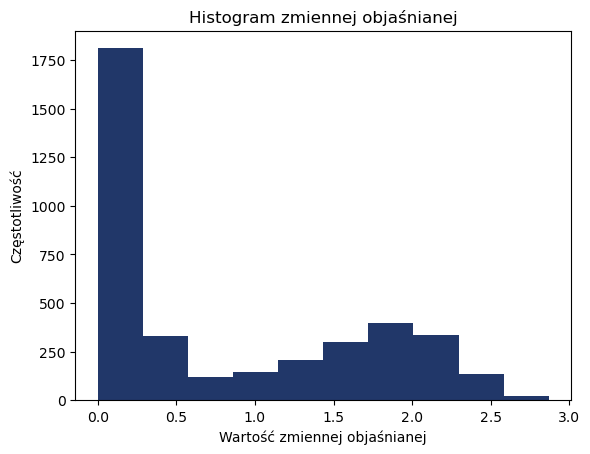

/tmp/ipykernel_12923/115046794.py:11: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




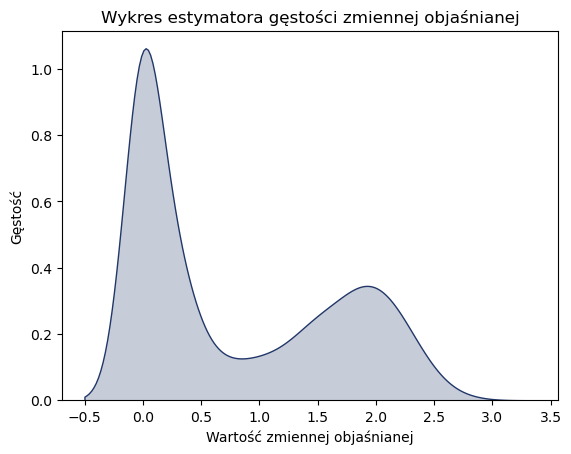

Statystyki dla obserwacji z wartościami >0.5
count    1704.000000
mean        1.660231
std         0.523266
min         0.501343
25%         1.317944
50%         1.756223
75%         2.052052
max         2.869365
Name: Expected, dtype: float64


In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

print(y_train_df["Expected"].describe())
plt.hist(y_train_df["Expected"], color="#213769")
plt.title('Histogram zmiennej objaśnianej')
plt.xlabel('Wartość zmiennej objaśnianej')
plt.ylabel('Częstotliwość')
plt.show()

sns.kdeplot(y_train_df["Expected"], shade=True, color="#213769")
plt.title('Wykres estymatora gęstości zmiennej objaśnianej')
plt.xlabel('Wartość zmiennej objaśnianej')
plt.ylabel('Gęstość')
plt.show()

print("Statystyki dla obserwacji z wartościami >0.5")
print(y_train_df[y_train_df["Expected"] > 0.5]["Expected"].describe())


mean        0.789212
std         0.867207
min         0.000000
25%         0.000000
50%         0.303113
75%         1.667722
max         2.869365
Średnia wartość naszej zmiennej objaśnianej to 0.79, jednak odchylenie standardowe to 0.87, 25% centyl to 0.0, zaś wartosć największa wynosi 2.87, więc dużo więcej o rozkładzie danych mówią nam 2 powyższe wykresy - w naszych danych znajduje się bardzo dużo obserwacji z wartością 0 oraz bliską 0, od wartości ok. 0.5 dane rozkładaja się już nieco bardziej normalnie, z dominantą ok wartości 2. 

In [44]:
top250 = x_train_df.corrwith(y_train_df["Expected"], axis=0, method='spearman').abs().sort_values(ascending=False).head(250)
corr = x_train_df[top250.index].corr(method='spearman')

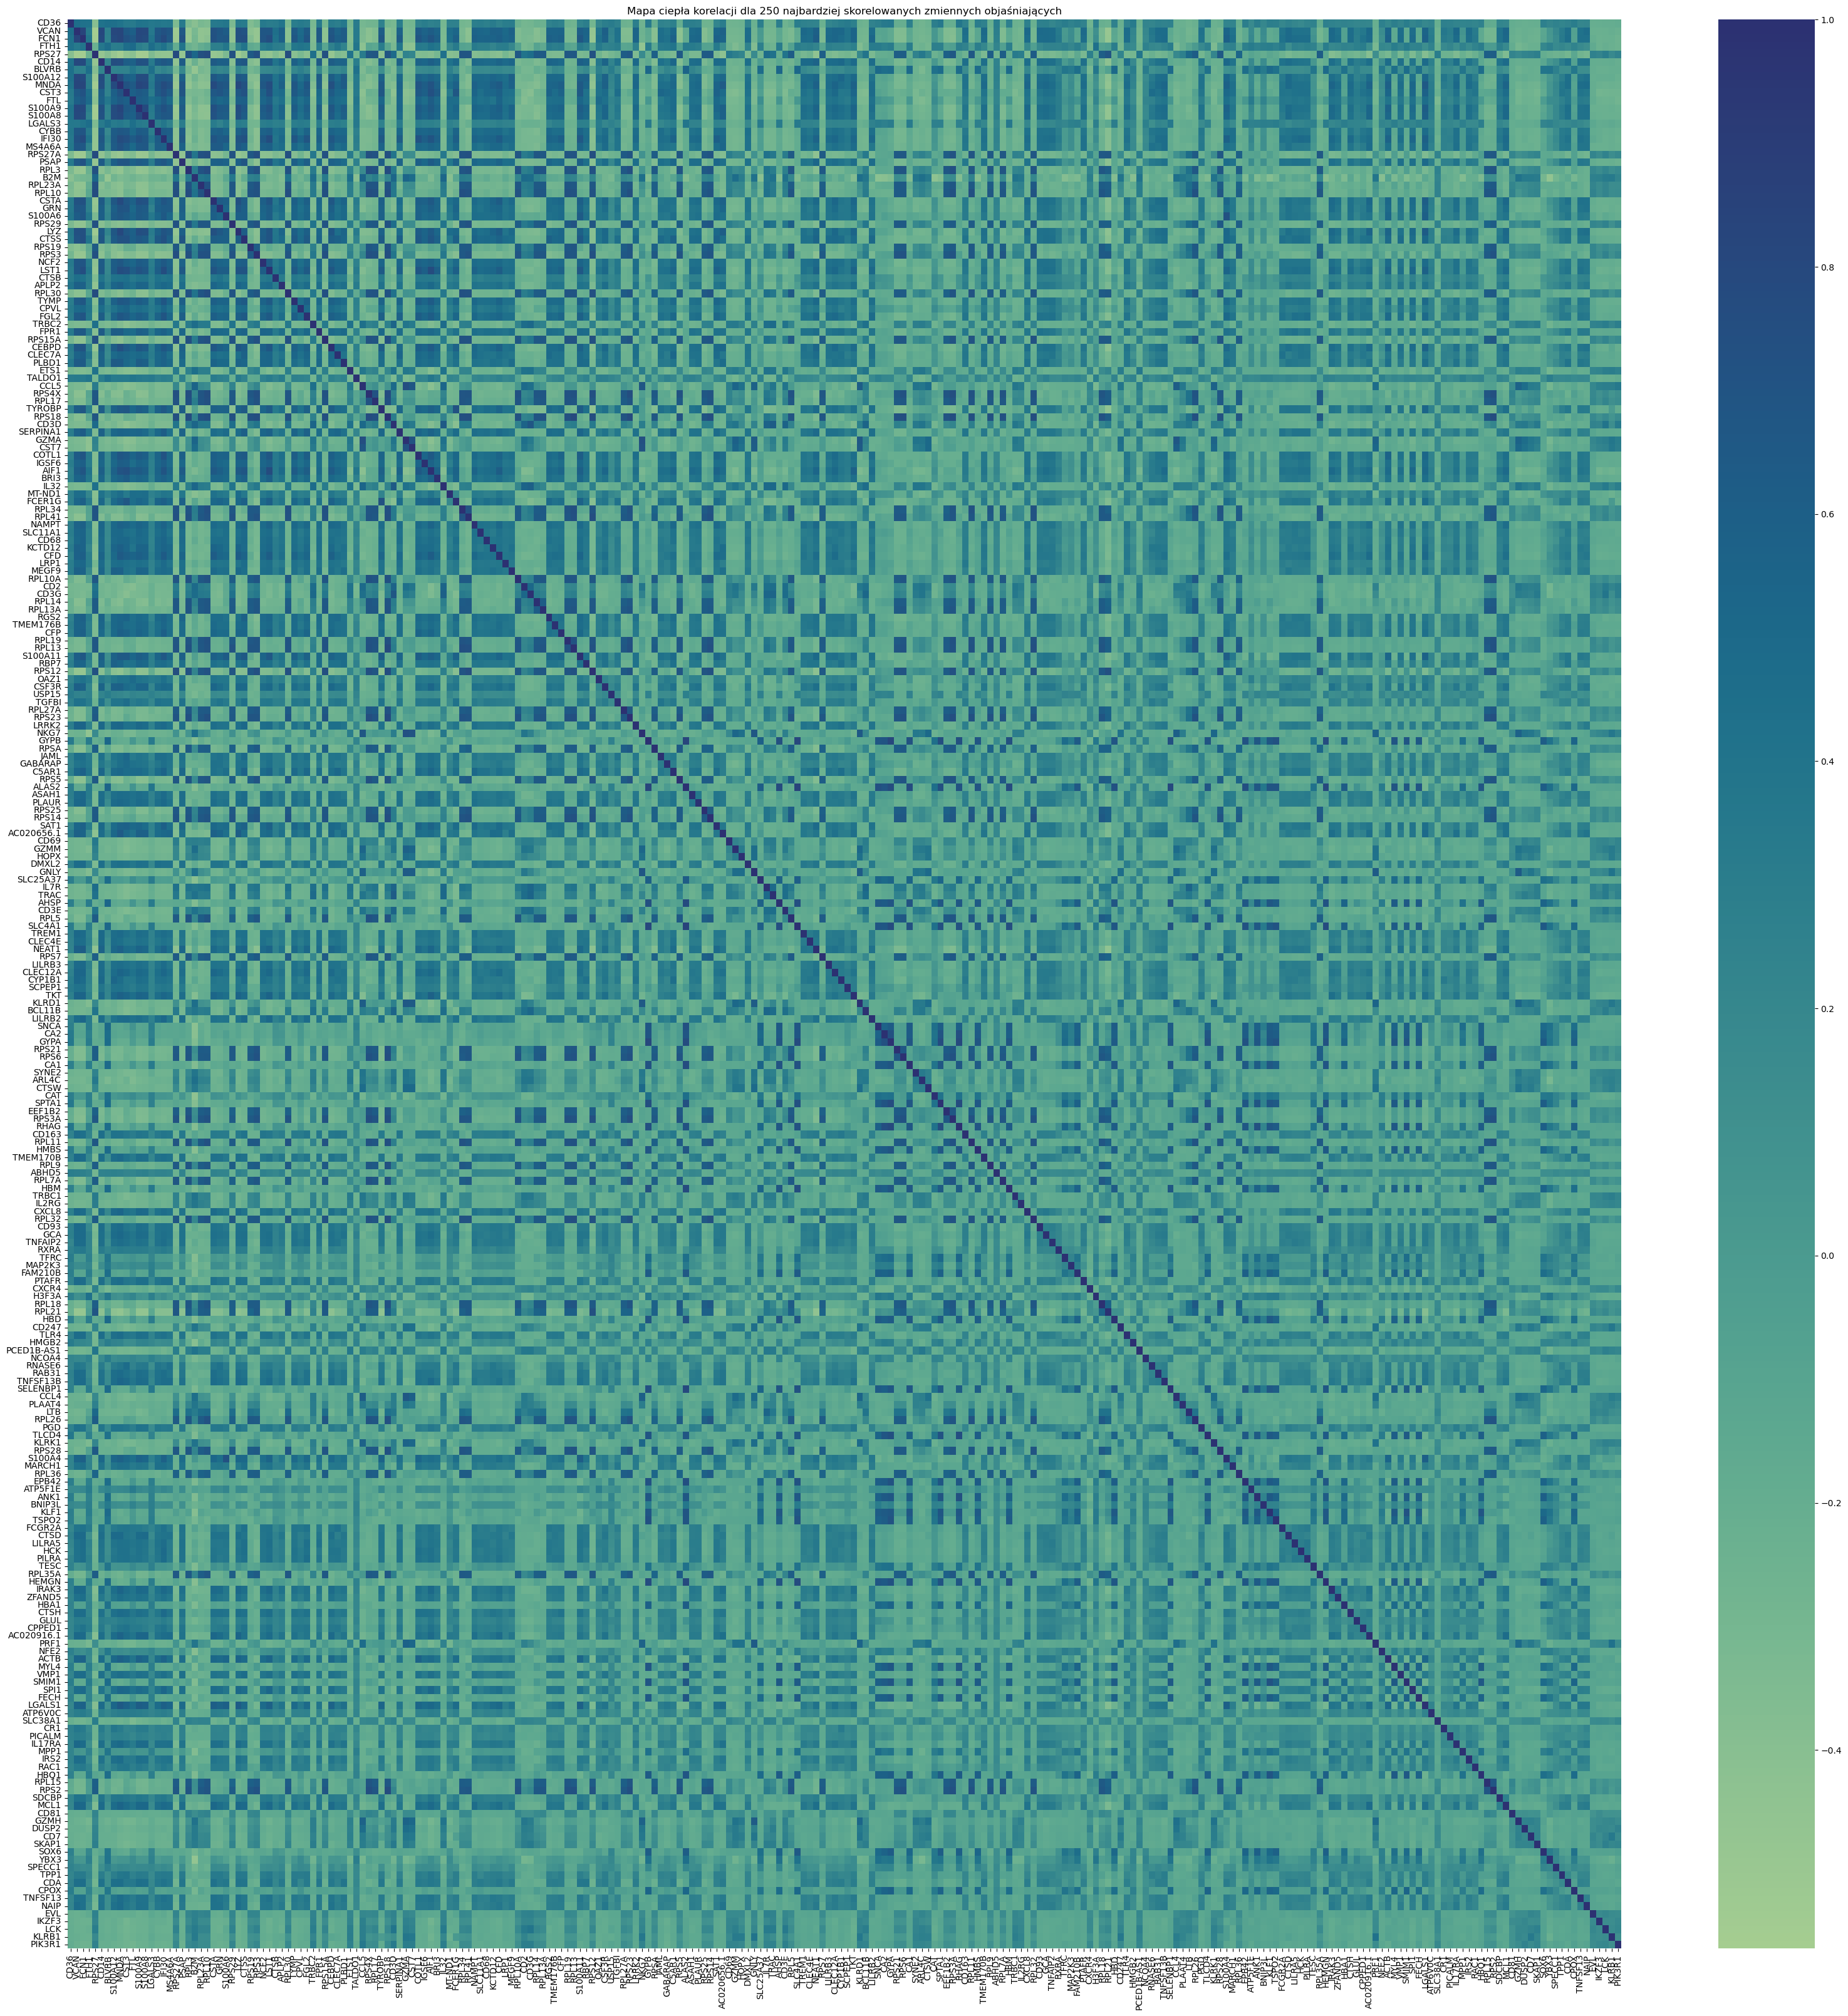

In [45]:
plt.figure(figsize=(40, 40))
sns.heatmap(corr, annot=False, fmt='.2f', cmap=sns.color_palette("crest", as_cmap=True),
            xticklabels=top250.index, yticklabels=top250.index)
plt.title('Mapa ciepła korelacji dla 250 najbardziej skorelowanych zmiennych objaśniających')
plt.show()

Powyższa mapa powstała na podstawie współczynnika korelacji spearmana, wiem, że przez uwzględnienie wszystkich zmiennych jako podpisy osi jest ona troche nieczytelna na podgladzie, jednak gdy pobierzemy obrazek i przyblizymy, to bedziemy w stanie odczytac wspolczynnik pomiędzy dowolnymi 2 zmiennymi

### Zadanie 2. ElasticNets
walidacja krzyżowa z 3 podzbiorami

In [1]:
!pip3 install "numpy>=1.17.5,<1.25.0" 

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 1.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.3
    Uninstalling numpy-1.26.3:
      Successfully uninstalled numpy-1.26.3


In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
import numpy as np

param_grid = {
    'alpha': [0.1, 0.3, 0.5, 0.7, 0.9],  # Zawiera przypadki ridge (0), mieszane (0.5) i lasso (1)
    'l1_ratio': [0.0, 0.5, 1.0]  # Regulacja siły regularyzacji
}

elastic_net = ElasticNet()

grid_search = GridSearchCV(elastic_net, param_grid, cv=3)

# Podział danych na zestaw treningowy i testowy
X_train, X_val, y_train, y_val = train_test_split(x_train_df, y_train_df, test_size=0.3, random_state=42)

In [ ]:
grid_search.fit(X_train, y_train)

# Najlepsze hiperparametry
best_params = grid_search.best_params_
print("Najlepsze hiperparametry:", best_params)

# Błąd treningowy i walidacyjny
train_error = np.mean((grid_search.predict(X_train) - y_train_df) ** 2)
val_error = np.mean((grid_search.predict(X_val) - y_val) ** 2)
print("Błąd treningowy:", train_error)
print("Błąd walidacyjny:", val_error)

In [4]:
from sklearn.ensemble import RandomForestRegressor

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'max_features': ['auto', 'sqrt', 'log2']
}

rf = RandomForestRegressor(random_state=42)

grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=3, n_jobs=-1)

# Dopasowanie modelu
grid_search_rf.fit(X_train, y_train)